Notes from Josh:

This is a largely unmodified file I received from Siddarth Aananth. It is used to build the starting model from scratch and is included in this repository for reference. He had originally trained the model for 50 epochs, but since his notes said 10 seemed to be the sweet spot, that is what I ran it for.

# Disease Detection Model - Corn (Experimentation File)

**Note:** Not the best structured file since I am only using it for experimentation purposes and trying out new things, will create another code base with well documented code and well definied experiments.

In [1]:
#importing libraries
import os
import numpy as np
import torch # Note: Using pytorch instead of Tensorflow
import torch.nn as nn
from torch.utils.data import DataLoader
import splitfolders
import torchvision
from torchvision import models, transforms
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import random

In [2]:
torch.cuda.is_available()

False

In [3]:
# Setting up the device to be used
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)
print("Switching device to available device")
device = torch.device(device)

Device:  cpu
Switching device to available device


## Actual Data Preprocessing and Exploration

**Note:** So the reason this is called 'Actual Data' is because we will have to run the below code on multiple versions of processed data - I am referring to the image filters implemented so I can reduce the size of images. Just one of the experiments for ApproximateComputing

In [4]:
# Plotting a few images to get a better understanding of the data
def view_random_image(target_folder: str):
  random_image = random.sample(os.listdir(target_folder), 15)
  fig, ax = plt.subplots(3, 5, figsize=(15, 10))
  for i in range(15):
    plt.subplot(3, 5, i+1)
    img = mpimg.imread(target_folder + '/' + random_image[i])
    plt.imshow(img)
    

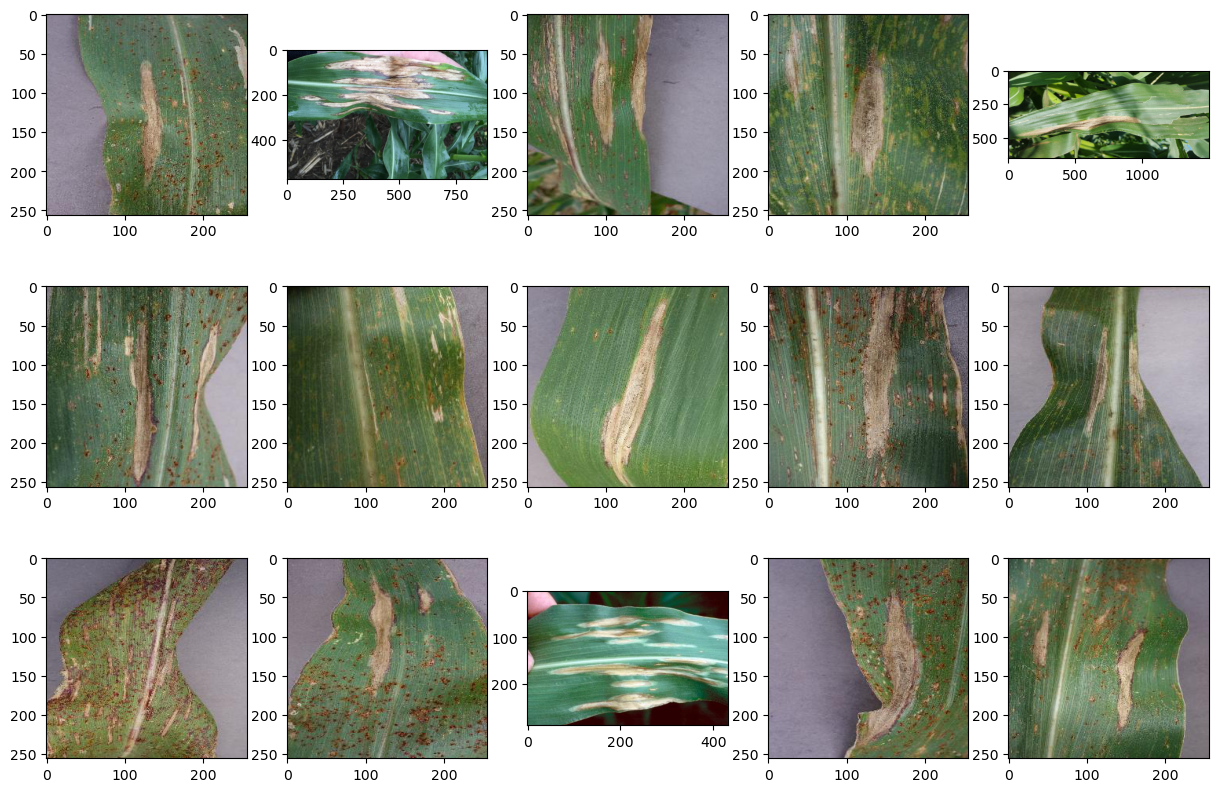

In [5]:
# First Class: Blight
view_random_image('data/Blight')

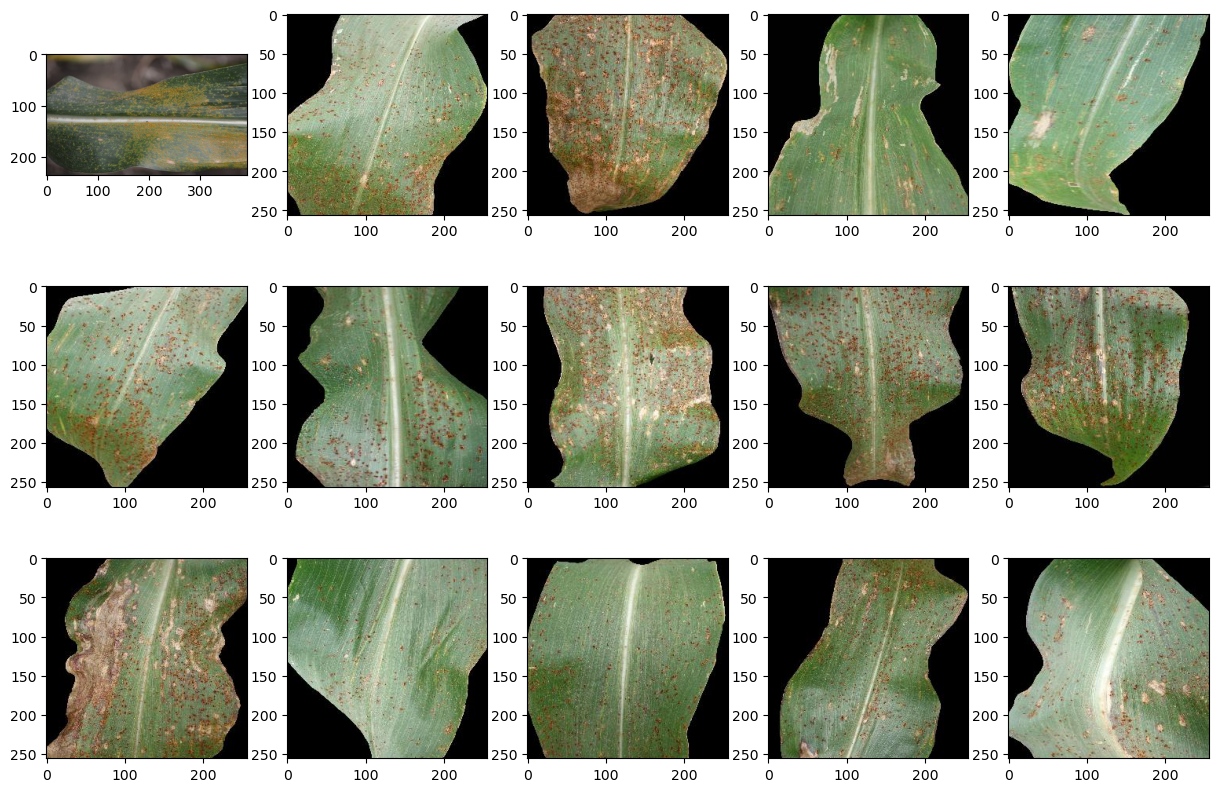

In [6]:
# Second Class: Common Rust
view_random_image('data/Common_Rust')

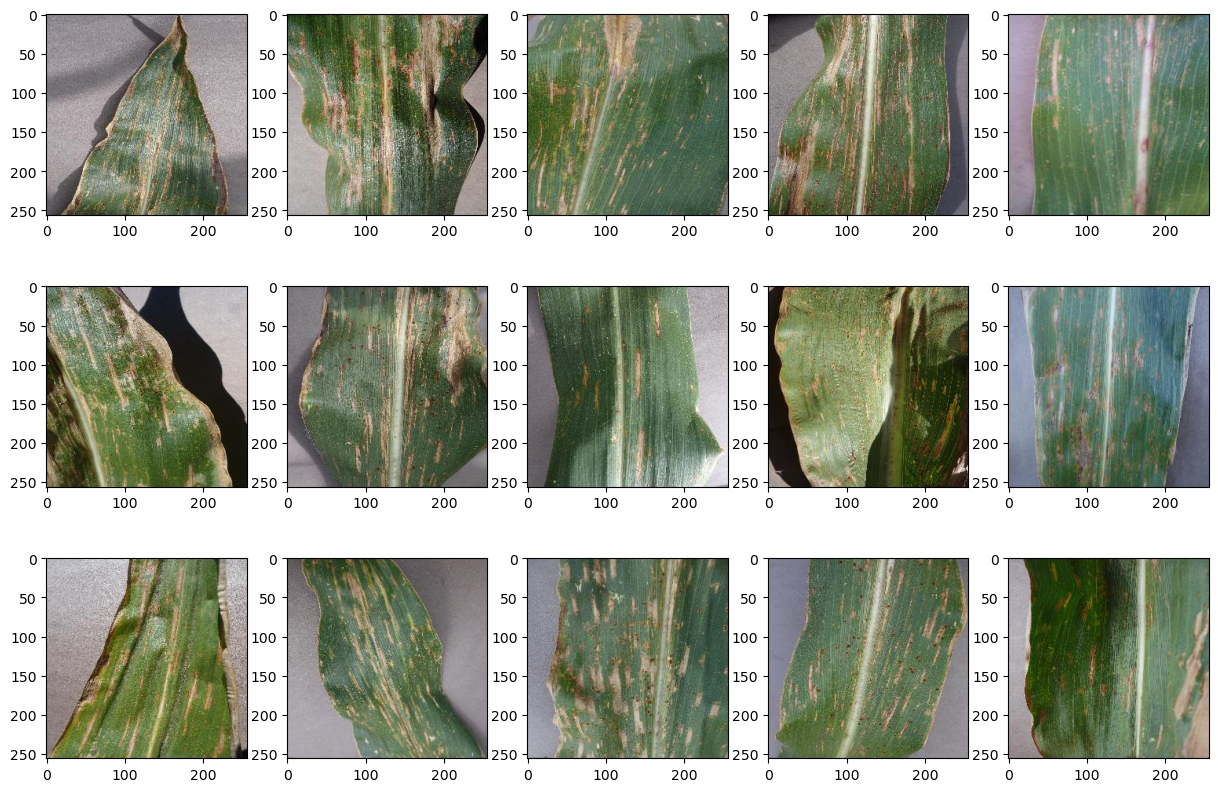

In [7]:
# Third Class: Gray Leaf Spot
view_random_image('data/Gray_Leaf_Spot')

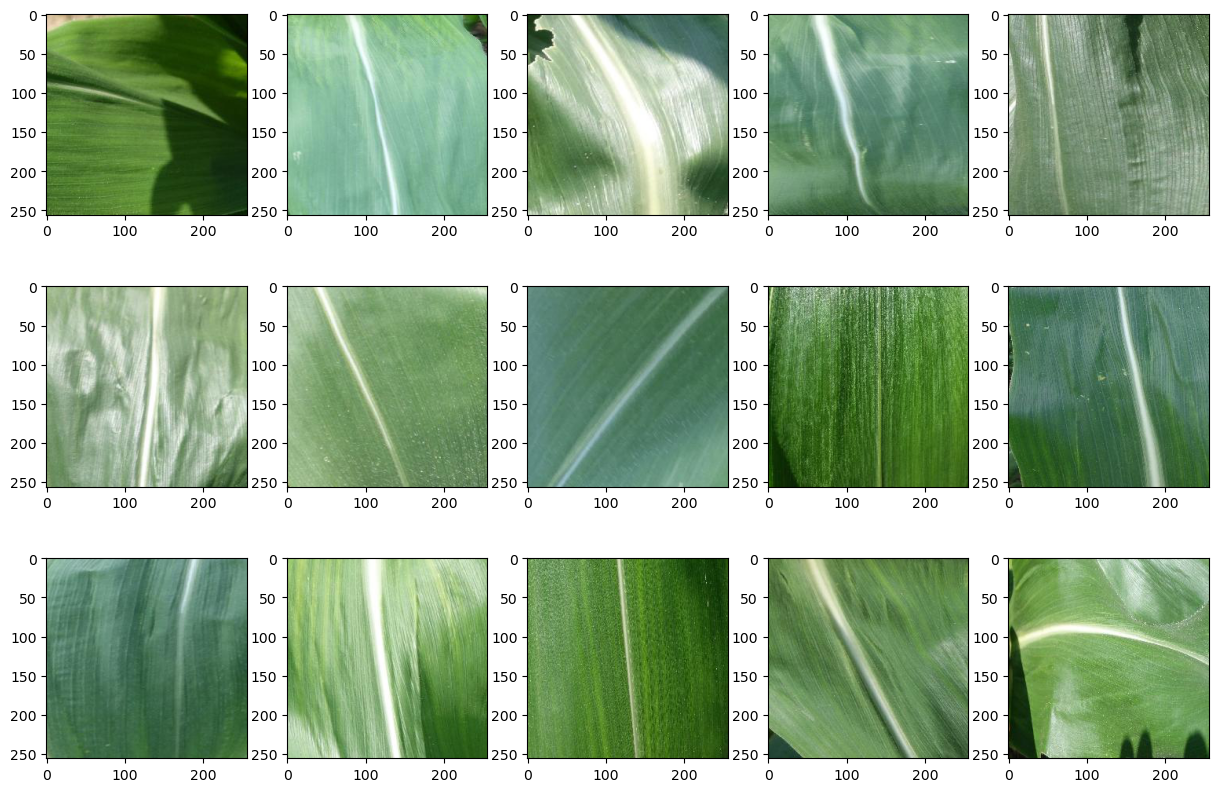

In [8]:
# Healthy Leaves
view_random_image("data/Healthy")

In [5]:
# Splitting the data into train, and validation sets

# Commenting code since this is done once and there is no need to re-run it
splitfolders.ratio("C:\\Users\\user\\Documents\\Classes\\CS597 Summer 2023\\data", 
                   output = "split_data", 
                   seed = 42, 
                   ratio = (.70, .20, .10), 
                   group_prefix = None,
                   move = False)

In [6]:
train_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)), 
    transforms.RandomHorizontalFlip(), 
    transforms.RandomVerticalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std = [0.229, 0.224, 0.225]) # Ref. calculation of these values
])

# In the training set, I will be using a lot more data filters while experimenting (subsquent cells)

val_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std = [0.229, 0.224, 0.225])
])

# Code for test set if needed, I think I only need the validation set to see the different results

test_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std = [0.229, 0.224, 0.225])
])

# Will also explore by applying some of the filters to the validation set and test set, to mimic the case where in the farm we would take images from the field, 
# apply filters and only then transfer to edge device where inference is going to be run

In [7]:
# Loading the data into train and val

train = torchvision.datasets.ImageFolder(root = "C:\\Users\\user\\Documents\\Classes\\CS597 Summer 2023\\split_data\\train", transform = train_transform)
val = torchvision.datasets.ImageFolder(root = "C:\\Users\\user\\Documents\\Classes\\CS597 Summer 2023\\split_data\\val", transform = val_transform)
test = torchvision.datasets.ImageFolder(root = "C:\\Users\\user\\Documents\\Classes\\CS597 Summer 2023\\split_data\\test", transform = test_transform)
type(train)

torchvision.datasets.folder.ImageFolder

In [8]:
# Creating ther data loadersusing the above datasets
batch_size = 32
train_dl = DataLoader(train, batch_size, shuffle = True)
val_dl = DataLoader(val, batch_size, shuffle = True)
test_dl = DataLoader(test, batch_size, shuffle = True)

**TODO:** Need to work on the filters and experiment with that too...

## Pre-Trained Models and Transfer Learning

### Resnet Models

In [9]:
# Setting up the resnet18 model
model = models.resnet18(pretrained = True)
model.fc = nn.Linear(in_features = 512, out_features = 4)
model = model.to(device)
print(model)


c:\Users\user\anaconda3\envs\NeuralNetworkPruning\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\anaconda3\envs\NeuralNetworkPruning\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
# Loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=10e-3)

In [11]:
def train_mode(model, train_loader, optimizer, loss_fn, device):
    model.train()  # Set the model to training mode
    criterion = loss_fn
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    avg_loss = total_loss / len(train_loader)
    accuracy = 100.0 * correct / total

    return avg_loss, accuracy

In [12]:
def validate_model(model, test_loader, loss_fn, device):
    model.eval()  # Set the model to evaluation mode
    criterion = loss_fn
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = total_loss / len(test_loader)
    accuracy = 100.0 * correct / total

    return avg_loss, accuracy


Epoch 1/10:
Training Loss: 0.3977 | Training Accuracy: 85.39%
Validation Loss: 0.1923 | Validation Accuracy: 92.94%

Epoch 2/10:
Training Loss: 0.1812 | Training Accuracy: 93.45%
Validation Loss: 0.1525 | Validation Accuracy: 93.18%

Epoch 3/10:
Training Loss: 0.1298 | Training Accuracy: 95.63%
Validation Loss: 0.1213 | Validation Accuracy: 96.17%

Epoch 4/10:
Training Loss: 0.1176 | Training Accuracy: 95.94%
Validation Loss: 0.1200 | Validation Accuracy: 95.69%

Epoch 5/10:
Training Loss: 0.0911 | Training Accuracy: 97.03%
Validation Loss: 0.1072 | Validation Accuracy: 96.29%

Epoch 6/10:
Training Loss: 0.0858 | Training Accuracy: 96.86%
Validation Loss: 0.1059 | Validation Accuracy: 96.05%

Epoch 7/10:
Training Loss: 0.0677 | Training Accuracy: 97.78%
Validation Loss: 0.1106 | Validation Accuracy: 95.93%

Epoch 8/10:
Training Loss: 0.0643 | Training Accuracy: 97.58%
Validation Loss: 0.0997 | Validation Accuracy: 96.53%

Epoch 9/10:
Training Loss: 0.0613 | Training Accuracy: 98.05%
Va

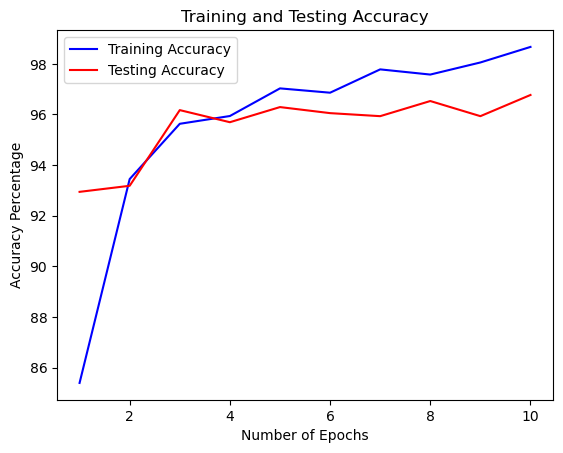

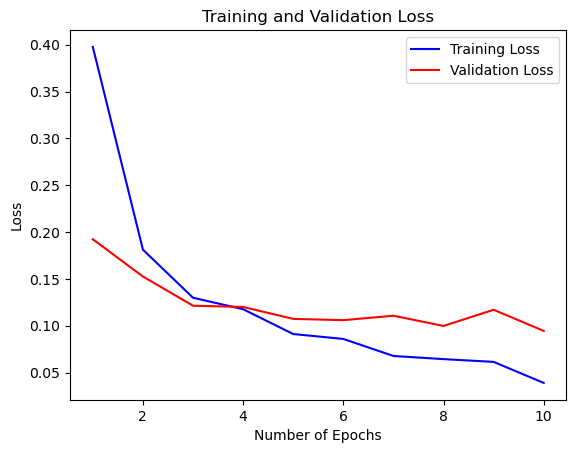

In [13]:
def train_and_validate(num_epochs):
    train_accuracies = []
    test_accuracies = []

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_mode(model, train_dl, optimizer, loss_fn, device)
        val_loss, val_accuracy = validate_model(model, val_dl, loss_fn, device)
        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"Training Loss: {train_loss:.4f} | Training Accuracy: {train_accuracy:.2f}%")
        print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.2f}%")
        print()

        train_accuracies.append(train_accuracy)
        test_accuracies.append(val_accuracy)

        train_losses.append(train_loss)
        val_losses.append(val_loss)


    # Plotting the accuracies
    plt.plot(range(1, num_epochs + 1), train_accuracies, 'b', label='Training Accuracy')
    plt.plot(range(1, num_epochs + 1), test_accuracies, 'r', label='Testing Accuracy')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Accuracy Percentage')
    plt.title('Training and Testing Accuracy')
    plt.legend()
    plt.show()

    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, train_losses, 'b', label='Training Loss')
    plt.plot(epochs, val_losses, 'r', label='Validation Loss')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    
train_and_validate(10)

In [14]:
# Testing accuracy on the test set
def evaluate_model(model, test_loader, loss_fn, device):
    criterion = loss_fn
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = total_loss / len(test_loader)
    accuracy = 100.0 * correct / total

    print(f"Test Loss: {avg_loss:.4f} | Test Accuracy: {accuracy:.2f}%")

evaluate_model(model, test_dl, loss_fn, device)

Test Loss: 0.1397 | Test Accuracy: 95.97%


#### Conclusion:
* As we can see from the above curve, 10 epochs seems to be a sweet spot for using this Pre-Trained Resnet18 Model
* Will compare results with untrained version of resnet18 (training model myself....just to see the accuracy difference)
* As far as ResNet models are concerned, there is no point in trying a deeper variant like resnet 50 since we have a relatively small dataste and may cause overfitting


In [25]:
# save the model
torch.save(model.state_dict(), "CornDiseaseDetection.pt")